In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ndvi-landcover/hacktest.csv
/kaggle/input/ndvi-landcover/hacktrain.csv
/kaggle/input/summer-analytics-mid-hackathon/hacktest.csv
/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv


# **NDVI-Based Land Cover Classification**

## **1. Objective**
this notebook tackles a **multiclass classification** problem using **NDVI(Normalized Difference Vegetation Index)** time series data, using **Logistic Regression only**.

we'll apply:
* Imputation for missing values
* Denoising of time series
* feature engineering
* Multinomial Logistic Regression
* Performance evaluation
* Final prediction submission
    


## **2. Dataset Prediction**
* hacktrain.csv: Noisy NDVI traing data
* hacktest.csv: 89% noisy, 11% cleamn NDVI test data

## **3. Importing Required Libraries & Loading Data**

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

train = pd.read_csv('/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv')
test = pd.read_csv('/kaggle/input/summer-analytics-mid-hackathon/hacktest.csv')

## **4. Preprocessing**

In [3]:
# Identify NDVI columns
ndvi_cols = [col for col in train.columns if '_N' in col]

# Check for Missing Values
train[ndvi_cols].isnull().sum().sort_values(ascending=False).head()

# Impute Missing Values(Median Strategy)
train[ndvi_cols] = train[ndvi_cols].fillna(train[ndvi_cols].median())
test[ndvi_cols] = test[ndvi_cols].fillna(test[ndvi_cols].median())

# Denoising with Rolling Mean(Noise Reduction)
train[ndvi_cols] = train[ndvi_cols].T.rolling(window=3, axis=1, min_periods=1).mean().T
test[ndvi_cols] = test[ndvi_cols].T.rolling(window=3, axis=1, min_periods=1).mean().T

print(train[ndvi_cols].isnull().sum().sum())
print(train[ndvi_cols].head())

0
   20150720_N   20150602_N   20150517_N   20150501_N   20150415_N  \
0  637.595000   658.668000 -1882.030000 -1924.360000   997.904000   
1  635.917500   626.186500 -1753.910000 -1798.340000   956.051000   
2  443.284133  -115.595667   388.060000 -1549.770000  1166.114000   
3  254.925133  1502.640000  1142.215333 -1327.293333  1005.414333   
4  422.325133  3142.530000  3241.478667  -220.576667  1345.948333   

    20150330_N   20150314_N   20150226_N   20150210_N   20150125_N  ...  \
0 -1739.990000   630.087000  5831.120000 -1325.640000  -944.084000  ...   
1 -1216.188000   668.856500  2080.265000 -1367.140000  -966.684500  ...   
2 -1332.335333  1379.907667  1630.106667 -1965.473333  1528.458667  ...   
3 -1223.398667   902.231333   -85.848667 -2466.726667  1420.640000  ...   
4   921.558333  1386.016000  2414.721333 -1582.890000   868.385000  ...   

    20140610_N   20140525_N  20140509_N  20140423_N   20140407_N   20140322_N  \
0  5484.905000 -1043.160000  -1942.4900  267.138000

/tmp/ipykernel_13/4003422690.py:12: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  train[ndvi_cols] = train[ndvi_cols].T.rolling(window=3, axis=1, min_periods=1).mean().T
/tmp/ipykernel_13/4003422690.py:13: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  test[ndvi_cols] = test[ndvi_cols].T.rolling(window=3, axis=1, min_periods=1).mean().T


## **4. Feature Engineering**

extract key features that summarize NDVI over time:

In [4]:
def extract_features(df):
    f = pd.DataFrame()
    f['mean_ndvi'] = df[ndvi_cols].mean(axis=1)
    f['std_ndvi'] = df[ndvi_cols].std(axis=1)
    f['max_ndvi'] = df[ndvi_cols].max(axis=1)
    f['min_ndvi'] = df[ndvi_cols].min(axis=1)
    f['range_ndvi'] = f['max_ndvi'] - f['min_ndvi']
    return f

X_train = extract_features(train)
X_test = extract_features(test)

print(X_train,X_test)

        mean_ndvi     std_ndvi     max_ndvi     min_ndvi   range_ndvi
0      274.827407  1917.252393  5831.120000 -2203.020000  8034.140000
1      117.352057  1515.113766  5484.905000 -2226.510000  7711.415000
2      254.830216  1180.614863  3314.643333 -2218.380000  5533.023333
3      196.568957  1053.054304  1547.335000 -2466.726667  4014.061667
4      676.212647  1221.154982  3241.478667 -1582.890000  4824.368667
...           ...          ...          ...          ...          ...
7995  2758.315074  1456.612311  5061.416667   497.763333  4563.653333
7996  2015.992321   912.131398  3709.716667   492.266000  3217.450667
7997  1441.896235   669.037605  3568.333333   632.796000  2935.537333
7998  1805.940290   705.456220  2854.598333   532.607667  2321.990667
7999  2633.876926  1143.201608  4691.579333   967.490333  3724.089000

[8000 rows x 5 columns]         mean_ndvi     std_ndvi     max_ndvi     min_ndvi   range_ndvi
0     3343.529778  2477.036970  7466.420000   340.949000  7125.47

## **5. Target Labels Encoding**

In [5]:
le = LabelEncoder()
train['class_encoded'] = le.fit_transform(train['class'])

## **6. Train Logistic Regression Model**

In [6]:
X_train = train[ndvi_cols]
Y_train = train['class_encoded']

model = LogisticRegression(max_iter=5000, multi_class='multinomial', class_weight='balanced')
model.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced', max_iter=5000,
                   multi_class='multinomial')

## **7. Predict on Test Set**

In [7]:
X_test = test[ndvi_cols]
Y_pred_encoded = model.predict(X_test)
Y_pred = le.inverse_transform(Y_pred_encoded)

## **8. Create Submission File**

In [8]:
submission = pd.DataFrame({
    'ID': test['ID'],
    'class': Y_pred
})
submission.to_csv('submission.csv', index=False)

print(submission.head())

# Checking whether the model is predicting all six classes
print(np.unique(Y_pred, return_counts=True))

   ID    class
0   1  orchard
1   2  orchard
2   3  orchard
3   4  orchard
4   5  orchard
(array(['farm', 'forest', 'grass', 'impervious', 'orchard', 'water'],
      dtype=object), array([ 697, 1148,  313,  385,  124,  178]))


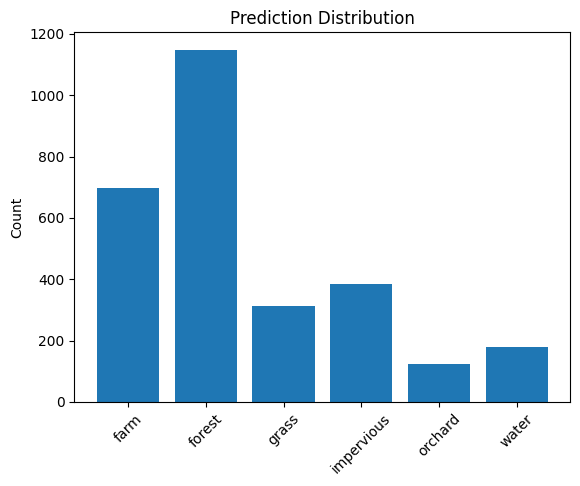

In [9]:
# Checking for the Distribution clearly
import matplotlib.pyplot as plt

labels, counts = np.unique(Y_pred, return_counts=True)
plt.bar(labels, counts)
plt.title("Prediction Distribution")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## **9. Visualisation**

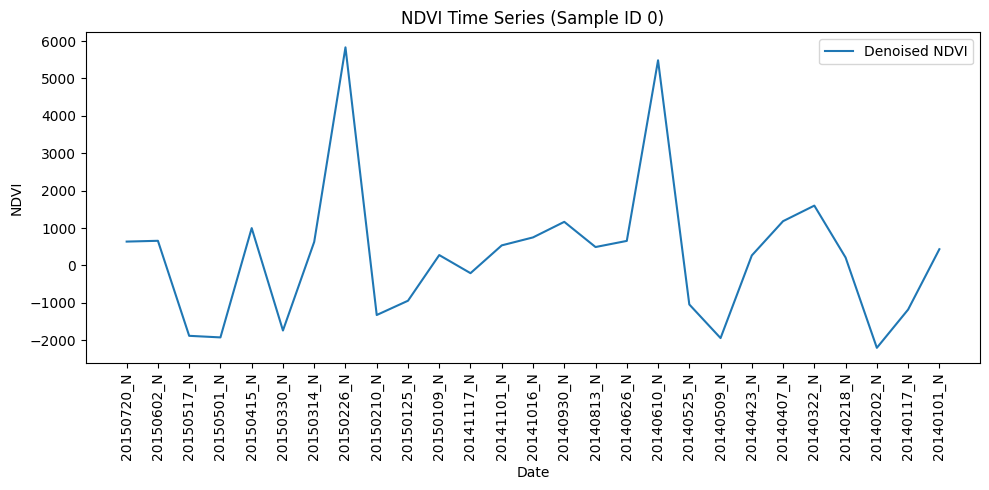

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train.loc[0, ndvi_cols], label='Denoised NDVI')
plt.title('NDVI Time Series (Sample ID 0)')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

## **10. Conclusion**
* Trained multinomial logistic regression on smoothed and imputed NDVI features.
* Used rolling average to reduce noise from cloud distortion.
* Created statistical summaries of NDVI as features (mean, std, range).
* Ready for leaderboard evaluation with robustness in mind.